# Tutorial 4: Forest Fires with All Factors

So far, we have discussed the effect of terrain, vegetation type, and wind on fire spread. We will now combine all of these methods in order to get a robust model of fire movement and then explore the effects a common anti-fire tactic of firelines to see how the fire's behaviour changes.


First, we'll rewrite some of the basics from the first tutorial to set up our model.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools

empty = 0
unburned = 1
burning = 2 
burned = 3

In [2]:
def create_world(n, q):
    world = np.zeros((n+2, n+2))
    forest = world[1:-1, 1:-1]
    forest[:, :] = np.random.choice([0, 1], p=[1-q, q], size=(n, n))
    return world

def show_world(W, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'jet'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 3
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    if title is None:
        num_trees = (W > 0).sum()
        if num_trees > 0:
            num_burnt = (W == 3).sum()
            percent = num_burnt / num_trees * 1e2
            title = '{} / {} ~= {:.1f}%'.format(num_burnt, num_trees, percent)
        else:
            title = ''
    plt.title(title)
    pass

def is_empty(W):
    return W == empty

def is_vegetation(W):
    return W > empty

def is_unburned(W):
    return W == 1

def is_burning(W):
    return W == 2

def is_burned(W):
    return W == 3

def count(W, cond_fun):
    return cond_fun(W).sum()

def summarize_world(W):
    def suffix(n):
        return (1, "tree") if n == 1 else (n, "trees")
    m, n = W.shape[0]-2, W.shape[1]-2
    n_trees = count(W, is_vegetation)
    n_unburned = count(W, is_unburned)
    n_burning = count(W, is_burning)
    n_burned = count(W, is_burned)
    
    print("The world has dimensions: {} x {}".format(m, n))
    print("There are {} cell(s) that have had vegetation in them".format(n_trees))
    print("There are {} cell(s) of vegetation that are unburned".format(n_unburned))
    print("There are {} cell(s) of vegetation on fire".format(n_burning))
    print("There are {} cell(s) of vegetation completely burned".format(n_burned))

def start_fire(W, cells=None):
    W_new = W.copy()
    
    if cells == None:
        F = W[1:-1, 1:-1]
        W_new = W.copy()
        F_new = W_new[1:-1, 1:-1]
        I, J = np.where(is_unburned(F)) # Positions of all trees
        if len(I) > 0:
            k = np.random.choice(range(len(I))) # Index of tree to ignite
            i, j = I[k], J[k]
            assert F_new[i, j] == 1, "Attempting to ignite a non-tree?"
            F_new[i, j] += 1
    else:
        W_new = W.copy()
        
        for x,y in cells:
            W_new[x,y] = 2
    
    return W_new


## Forest Type

Our Forest Type Functions are below. 

In [3]:
def create_transition_matrix(world, tree_type):
    if tree_type not in ['C', 'B', 'M']:
        raise ValueError('Tree type must be coniferous (\'C\'), Broadleaf (\'B\'), or mixed (\'M\')')
    
    probs = {'C': .9, 'B': .7}
    
    mat = np.ones(world.shape)
    
    if tree_type is 'M':
        mat = np.random.rand(*world.shape)
        
        c_index = mat < .5
        b_index = mat >= .5
        
        mat[c_index] = probs['C']
        mat[b_index] = probs['B']
        
    else:
        mat *= probs[tree_type]
    
    return mat

def show_tm(W, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'terrain'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 1
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    
    title = 'Types of trees (darker are more likely to burn)'
    
    plt.title(title)
    pass
    

## Terrain

Our terrain type functions copied over as well.

In [4]:
# create random elevations between 0 and 10 
def create_random_elevations(world):
    elevs = np.random.randint(0, 10, size=world.shape)
    
    return elevs
    
# add ridge of elevation 10 down the middle of the map
def add_middle_ridge(elevs):
    
    elevs[:, elevs.shape[1]//2] = 10
    
    return elevs

# create a map with 0 elevation on one half and increasing on the other
def create_increasing_elevations(world):
    elevs = np.zeros(world.shape)
    num_tiers = elevs.shape[1]//2
        
    tiers = np.linspace(1, num_tiers, num_tiers)
    
    r = num_tiers
    
    if elevs.shape[1] % 2:
        r += 1
    
    for i in range(1, r):
        elevs[:, num_tiers + i] = np.full((1, elevs.shape[0]), i)
    
    return elevs
    
def show_elevs(elevs, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'terrain'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = np.max(elevs)
    plt.figure(figsize=(8, 8))
    plt.matshow(elevs, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    
    title = 'Elevation'
    
    plt.title(title)
    pass

def elev_transition_prob(elevs_mat):
    kernel = np.matrix([[-1,-2,-1], [0,0,0], [1,2,1]])
    
    vert, row = np.gradient(elevs_mat)
    
    c0 = np.roll(row, 1, axis=1)
    c0[:, 0] = 0
    
    c1 = np.roll(vert, 1, axis=0)
    c1[0, :] = 0
    
    c = np.maximum(c0, c1)   
    
    diff = c.max() - c.min()
    if not diff: diff = 1

    c = (c - c.min()) / diff
        
    return c
    

## Combined Fire Spread

Below, we combine the elevation, terrain types, and wind.

1. First we take in wind as in tutorial 3 and factor it into our `num_neighbors_on_fire` and `fire_prob_matrix`

2. Next, we combine the effects of tree type with our `transition_matrix`

3. Finally, we take elevation into account with the elevation transition probability matrix (`elev_p`). Since this matrix also represents probabilities of fire spreading, we combine this and our earlier `fire_prob_matrix` by weighing each by half and adding them. More advanced models could look at different ratios between these factor and their effect on fire spread.

In [5]:
def spread_fire_all(W, transition_matrix, elevs, wind_args):
    wind_dir, wind_power = wind_args
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    
    # 1) WIND
    F1 = Fires[:-2, :-2]
    F2 = Fires[1:-1, :-2]
    F3 = Fires[2:, :-2]
    F4 = Fires[:-2, 1:-1]
    F5 = Fires[2:, 1:-1] 
    F6 = Fires[:-2, 2:]
    F7 = Fires[1:-1, 2:]
    F8 = Fires[2:, 2:]
  
    if wind_dir =='S':
        F4 = F4 *wind_power
        F5 = F5 *0   
    elif wind_dir =='N':
        F5 = F5 *wind_power
        F4 = F4 *0
        
    elif wind_dir =='W':
        F7 = F7 *wind_power
        F2 = F2 * 0    
        
    elif wind_dir =='E':
        F2 = F2 *wind_power
        F7 = F7 * 0 
        
    elif wind_dir =='SW':
        F6 = F6 *wind_power
        F3 = F3 *0
    elif wind_dir =='SE':
        F1 = F1 *wind_power
        F8 = F8 *0
        
    elif wind_dir =='NW':
        F8 = F8 *wind_power
        F1 = F1 *0
    elif wind_dir =='NE':
        F3 = F3 *wind_power
        F6 = F6 *0

    num_neighbors_on_fire = (F1 + F2 + F3 + F4 + F5 + F6 + F7 + F8)
  
    num_neighbors_on_fire = np.multiply(num_neighbors_on_fire, Vegetation[1:-1, 1:-1].astype(int))
    
    # 2) TREE TYPE
    fire_prob_matrix = np.ones(num_neighbors_on_fire.shape) - transition_matrix[1:-1, 1:-1]
    fire_prob_matrix = 1.0 - np.power(fire_prob_matrix, num_neighbors_on_fire)
        
    # 3) ELEVATION
    elev_p = elev_transition_prob(elevs)
    elev_p = elev_p[1:-1, 1:-1]
    elev_i = Vegetation[1:-1, 1:-1] \
                        & (
                              Fires[:-2, :-2]  | Fires[1:-1, :-2] | Fires[2:, :-2]
                            | Fires[:-2, 1:-1] |                    Fires[2:, 1:-1]
                            | Fires[:-2, 2:]   | Fires[1:-1, 2:]  | Fires[2:, 2:]
                           )
    
    e = np.multiply(elev_p, elev_i)
    fire_prob_matrix = .5 * fire_prob_matrix + .5 * e     
    
    # probabilistic transition
    fire_prob_matrix = np.multiply(fire_prob_matrix, Vegetation[1:-1, 1:-1].astype(int))
    
    # print('Final prob matrix', fire_prob_matrix)
    # print('Final prob max', np.max(fire_prob_matrix))

    randys = np.random.rand(*fire_prob_matrix.shape)
    new_on_fires = randys < fire_prob_matrix
    
    W_new[1:-1, 1:-1] += new_on_fires
 
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]
    
    return W_new



# Testing

The world has dimensions: 50 x 50
There are 2239 cell(s) that have had vegetation in them
There are 2238 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


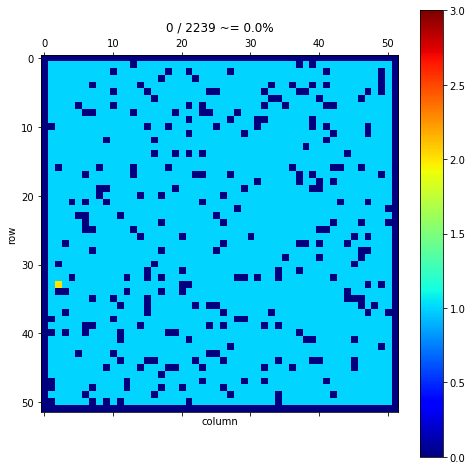

In [6]:
w = create_world(50, .9)
w = start_fire(w)
tm = create_transition_matrix(w, 'M')
e = create_increasing_elevations(w)

show_world(w)
summarize_world(w)

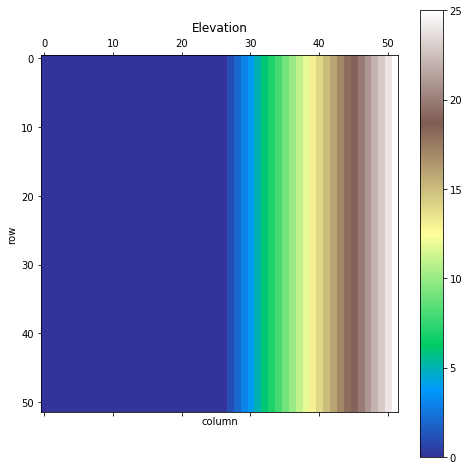

In [7]:
show_elevs(e)

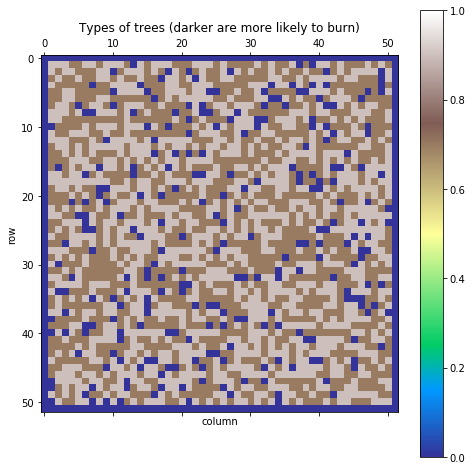

In [8]:
show_tm(np.multiply(tm, is_vegetation(w)))

The world has dimensions: 50 x 50
There are 2239 cell(s) that have had vegetation in them
There are 2236 cell(s) of vegetation that are unburned
There are 2 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


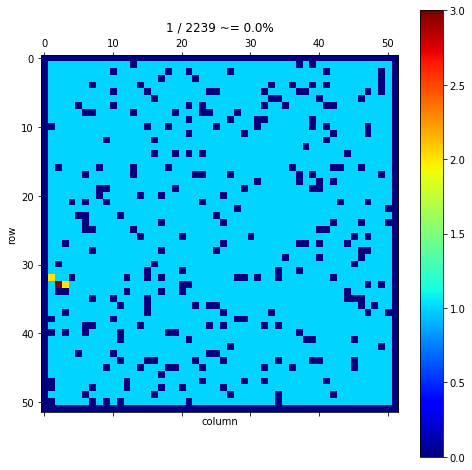

In [9]:
w = spread_fire_all(w, tm, e, ('E', 10))
show_world(w)
summarize_world(w)

The world has dimensions: 50 x 50
There are 2249 cell(s) that have had vegetation in them
There are 2248 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


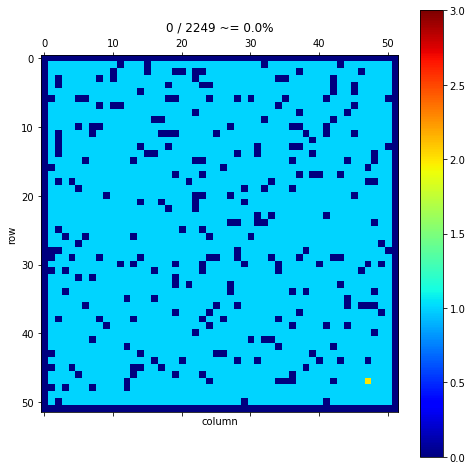

In [10]:
w = create_world(50, .9)
w = start_fire(w)
tm = create_transition_matrix(w, 'M')
e = create_increasing_elevations(w)

show_world(w)
summarize_world(w)

The world has dimensions: 50 x 50
There are 2249 cell(s) that have had vegetation in them
There are 2241 cell(s) of vegetation that are unburned
There are 7 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


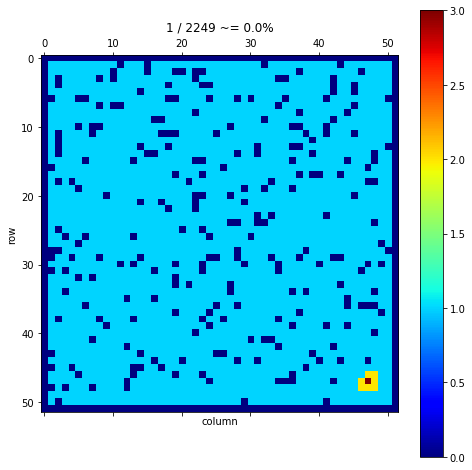

In [11]:
w = spread_fire_all(w, tm, e, ('W', 10))
show_world(w)
summarize_world(w)

## Simulations for All Factors

In [12]:
def simulate(W0, tree_type, elevs, wind_args, t_max=None, inplace=False):
    if t_max is None:
        n_max = max(W0.shape)
        t_max = n_max * ((2*n_max-1) // 2)
    W = np.zeros((W0.shape[0], W0.shape[1], 2 if inplace else t_max+1))
        
    tm = create_transition_matrix(W0, tree_type)

    t_cur = 0
    W[:, :, t_cur] = W0
    for t in range(t_max):
        t_next = (t_cur+1)%2 if inplace else t+1
        W[:, :, t_next] = spread_fire_all(W[:, :, t_cur], tm, elevs, wind_args)
        if (W[:, :, t_cur] == W[:, :, t_next]).all():
            t_cur = t_next
            break
        t_cur = t_next
    return (W[:, :, t_cur], t) if inplace else W[:, :, :t_cur+1]
    
def viz(W, t=0):
    show_world(W[:, :, t])
    plt.show()
    print("At time {} (max={})...".format(t, W.shape[2]-1))
    summarize_world(W[:, :, t])
    
def run_simulation(n, q, tree_type, e, wind_args, **args):
    
    w = create_world(n, q)
    w = start_fire(w)
    
    return simulate(w, tree_type, e, wind_args, **args)


In [13]:
def simulate_many(n, q, trials, tree_type, e, wind_args, **args):
    percent_burned = np.zeros(trials)
    time_to_burn = np.zeros(trials)    

    for trial in range(trials):
        W_last, t_last = run_simulation(n, q, tree_type, e, wind_args, inplace=True, **args)
        n_trees = count(W_last, is_vegetation)
        n_burnt = count(W_last, is_burned)
        percent_burned[trial] = n_burnt / n_trees if n_trees > 0 else 0.0
        time_to_burn[trial] = t_last
    return percent_burned, time_to_burn

## Analyzing effect of different parameter combos

In [14]:
n_many = 25

w_base = np.zeros((n_many + 2, n_many + 2))

tree_types = ['C', 'B']

e_raised = create_increasing_elevations(w_base)
e_flat = w_base
e_ridge = add_middle_ridge(w_base)

elevations = {'Gradient': e_raised, 'Flat': e_flat, 'Ridge': e_ridge}
e_keys = ['Gradient', 'Flat', 'Ridge']

wind_dir = ['N','S', 'E', 'W']

Percentages = np.zeros((len(wind_dir), len(e_keys), len(tree_types), 2))
Times = np.zeros((len(wind_dir), len(e_keys), len(tree_types), 2))

for i_w, w in enumerate(wind_dir):
    for i_e, e_key in enumerate(e_keys):
        for i_t, t in enumerate(tree_types):
            
            print("Simulating args: w={}, e={}, t={}...".format(w, e_key, t))
            
            percentages, times = simulate_many(n_many, 1, 100, t, elevations[e_key], (w, 10))
            Percentages[i_w, i_e, i_t, :] = [percentages.mean(), percentages.std()]
            Times[i_w, i_e, i_t, :] = [times.mean(), times.std()]
            

Simulating args: w=N, e=Gradient, t=C...
Simulating args: w=N, e=Gradient, t=B...
Simulating args: w=N, e=Flat, t=C...
Simulating args: w=N, e=Flat, t=B...
Simulating args: w=N, e=Ridge, t=C...
Simulating args: w=N, e=Ridge, t=B...
Simulating args: w=S, e=Gradient, t=C...
Simulating args: w=S, e=Gradient, t=B...
Simulating args: w=S, e=Flat, t=C...
Simulating args: w=S, e=Flat, t=B...
Simulating args: w=S, e=Ridge, t=C...
Simulating args: w=S, e=Ridge, t=B...
Simulating args: w=E, e=Gradient, t=C...
Simulating args: w=E, e=Gradient, t=B...
Simulating args: w=E, e=Flat, t=C...
Simulating args: w=E, e=Flat, t=B...
Simulating args: w=E, e=Ridge, t=C...
Simulating args: w=E, e=Ridge, t=B...
Simulating args: w=W, e=Gradient, t=C...
Simulating args: w=W, e=Gradient, t=B...
Simulating args: w=W, e=Flat, t=C...
Simulating args: w=W, e=Flat, t=B...
Simulating args: w=W, e=Ridge, t=C...
Simulating args: w=W, e=Ridge, t=B...


### Graphs

The following three charts let us examine these different combinations of Wind direction, tree type, and elevation. Interestingly, we see the same trends from our earlier analysis still hold true when isolated from the other factors. For instance, coniferous forests burn at a higher rate than broadleaf (graph 2) and forests with a gradient elevation burn at a higher rate than flat forests (graph 3). Similar graphs could be created for time analysis but is left to the user for exploration.

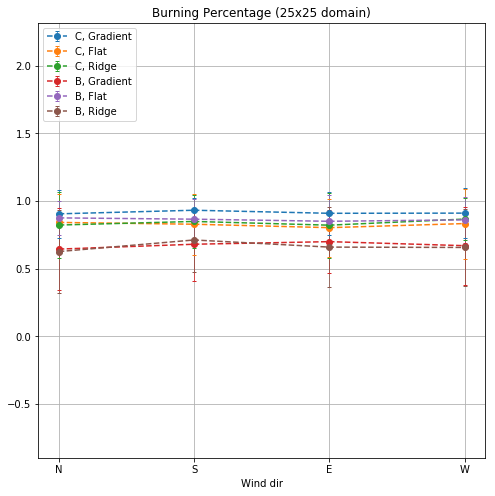

In [15]:
plt.figure(figsize=(8, 8))

for i in range(Percentages.shape[1]):
    for j in range(Percentages.shape[2]):
        plt.errorbar(wind_dir, Percentages[:, i, j, 0], yerr=Percentages[:, i, j, 1], fmt='o--', elinewidth=0.75, capsize=2);
            
            
plt.gca().axis('equal')
plt.xlabel('Wind dir');
plt.title('Burning Percentage ({}x{} domain)'.format(n_many, n_many));
plt.legend(map(', '.join, itertools.chain(itertools.product(e_keys, tree_types), itertools.product(tree_types, e_keys))), loc='upper left')
plt.grid()

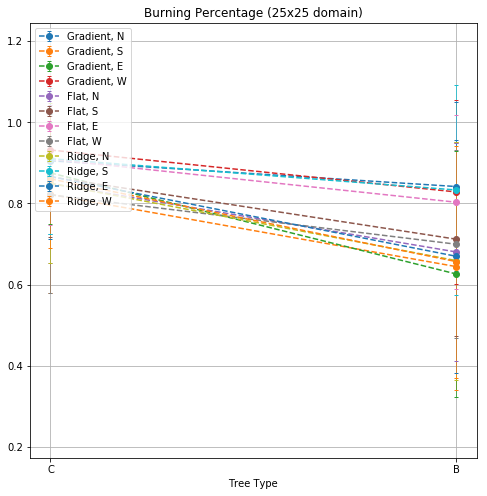

In [16]:
plt.figure(figsize=(8, 8))

for i in range(Percentages.shape[0]):
    for j in range(Percentages.shape[1]):
        plt.errorbar(tree_types, Percentages[i, j, :, 0], yerr=Percentages[i, j, :, 1], fmt='o--', elinewidth=0.75, capsize=2);
            
            
plt.gca().axis('equal')
plt.xlabel('Tree Type');
plt.title('Burning Percentage ({}x{} domain)'.format(n_many, n_many));
plt.legend(map(', '.join, itertools.chain(itertools.product(wind_dir, e_keys), itertools.product(e_keys, wind_dir))), loc='upper left')
plt.grid()

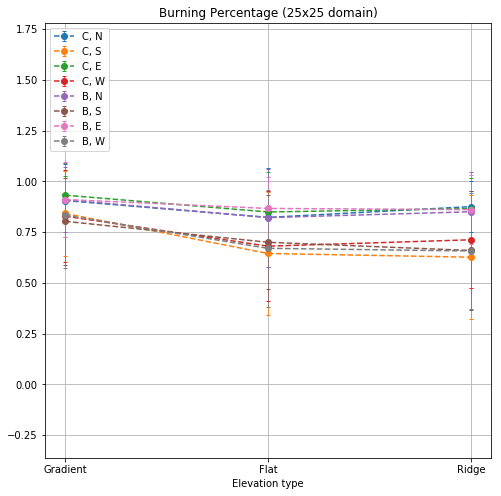

In [17]:
plt.figure(figsize=(8, 8))

for i in range(Percentages.shape[0]):
    for j in range(Percentages.shape[2]):
        plt.errorbar(e_keys, Percentages[i, :, j, 0], yerr=Percentages[i, :, j, 1], fmt='o--', elinewidth=0.75, capsize=2);
            
            
plt.gca().axis('equal')
plt.xlabel('Elevation type');
plt.title('Burning Percentage ({}x{} domain)'.format(n_many, n_many));
plt.legend(map(', '.join, itertools.chain(itertools.product(wind_dir, tree_types), itertools.product(tree_types, wind_dir))), loc='upper left')
plt.grid()

## Fire Line

Let's have some fun with this simulator we've built shall we?

In real life, forest fires tend to grow out of hand very quickly. There are several techniques that are able to help combat the spread. One of these is creating what is known as a Fire Line. Fire Lines are areas that have been cleared of vegetation, whether through manual labor or controlled burns, put in strategic spots so that the fire would have a hard time bridging that gap. It is a useful thing to simulate because this could help fire fighters see where to put a fire line to best slow down fire spreading. Below we'll walk through how to simulate a fire line.

First, let's make our world. In our case we're going to make our world have size `25x25`, and start a fire at `(5,5)`
For the sake of this demonstration, our fire lines will only be straight, and have a maximum line length of `15`. Let's start by importing the `interact` package from `ipywidgets` and also set our initial parameters. Let's also show our world just so we can visualize it better

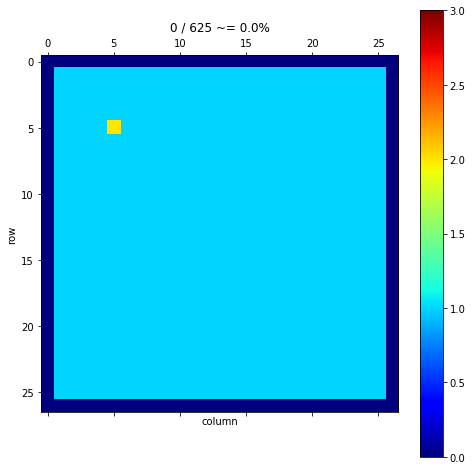

In [18]:
from ipywidgets import interact

world_size = 25
fire_start = (5,5)
max_line_length = 15
rand_seed = 42

# Coniferous Trees, Gradient elevation, East wind with strength 10
tree_type = 'C'
e_raised = create_increasing_elevations(w_base)
wind_dir = 'E'
wind_str = 10

np.random.seed(rand_seed)
W = create_world(world_size, 1.0)
W_next = start_fire(W, [fire_start])
show_world(W_next)

Now let's write the code that will help us visualize a vertical fire line. Setting the seed is necessary because every time a variable is changed interactively, `fireLineivizVert` is called again. Without a seed, the world generated would constantly change. The `fLine...` sliders decide the location of the fire line, and the `t` slider determines which time step frame to show! Go ahead, play around with the sliders and see what happens as you change t!

In [19]:
def fireLineivizVert(t=0, fLineStartX=0, fLineStartY=0, fLineLength=0):
    np.random.seed(rand_seed)
    W = create_world(world_size, 1.0)
    
    W[fLineStartY:fLineStartY+fLineLength, fLineStartX] = empty
    
    W_result = simulate(start_fire(W, [fire_start]), tree_type, e_raised, (wind_dir, wind_str))
    if t < W_result.shape[2]:
        viz(W_result, t);
    else:
        viz(W_result, W_result.shape[2] - 1)
    
interact(fireLineivizVert, t=(0, 40), fLineStartX=(1,world_size), fLineStartY=(1,world_size+1-max_line_length), fLineLength=(0,max_line_length))



interactive(children=(IntSlider(value=0, description='t', max=40), IntSlider(value=1, description='fLineStartX…

<function __main__.fireLineivizVert(t=0, fLineStartX=0, fLineStartY=0, fLineLength=0)>

Why stop at vertical fire lines, lets also make a horizontal fire line simulator!

In [20]:
def fireLineivisHoriz(t=0, fLineStartX=0, fLineStartY=0, fLineLength=0):
    np.random.seed(rand_seed)
    W = create_world(world_size, 1.0)
    
    W[fLineStartY, fLineStartX:fLineStartX+fLineLength] = empty
    
    W_result = simulate(start_fire(W, [fire_start]), tree_type, e_raised, (wind_dir, wind_str))
    if t < W_result.shape[2]:
        viz(W_result, t);
    else:
        viz(W_result, W_result.shape[2] - 1)
    
interact(fireLineivisHoriz, t=(0, 40), fLineStartX=(1,world_size+1-max_line_length), fLineStartY=(1,world_size), fLineLength=(0,max_line_length))



interactive(children=(IntSlider(value=0, description='t', max=40), IntSlider(value=1, description='fLineStartX…

<function __main__.fireLineivisHoriz(t=0, fLineStartX=0, fLineStartY=0, fLineLength=0)>

## Conclusion

Through these tutorials, we have been able to explore a variety of cellular automata models ranging from very basic to rather complex. We hope you have been able to see how different factors play into the spreading of fires in forests and how some basic things like fire lines can be used to shape the spread of a fire and curtail its effects.

Those interested in simulating fires based on real forests could hopefully utilize our model with empirical data on tree types and elevations to get a sense of how fires could spread in real forests in the world.